<a href="https://colab.research.google.com/github/stellagerantoni/LatentCfMultivariate/blob/main/PenDigits_KDE_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 ! git clone https://github.com/stellagerantoni/LatentCfMultivariate

Cloning into 'LatentCfMultivariate'...
remote: Enumerating objects: 272, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 272 (delta 118), reused 36 (delta 36), pack-reused 105
Receiving objects: 100% (272/272), 12.71 MiB | 21.13 MiB/s, done.
Resolving deltas: 100% (158/158), done.


In [2]:
!pip install -q wildboar
!pip install -q scikit-learn
!pip install -q stumpy
!pip install -q fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
!pip install aeon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 13.8 MB/s eta 0:00:00


In [4]:
import logging
import os
import warnings
from argparse import ArgumentParser
from aeon.datasets import load_classification

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.spatial import distance_matrix
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from wildboar.datasets import load_dataset
from wildboar.ensemble import ShapeletForestClassifier
from wildboar.explain.counterfactual import counterfactuals
%cd '/content/LatentCfMultivariate'
from _guided import ModifiedLatentCF
from help_functions import *
from keras_models import *

/content/LatentCfMultivariate


In [5]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
RANDOM_STATE = 39

# **ACTUALL CODE**


In [6]:
#Getting the dataset

RANDOM_STATE = 39
X,y = load_classification('PenDigits')
X = X.transpose(0,2,1)
print(f'shape of X = {X.shape}')
print(f'shape of y = {y.shape}')
#print(f'data imformation = {data_information}')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print(f'shape of X train = {X_train.shape}')
print(f'shape of y train = {y_train.shape}')

shape of X = (10992, 8, 2)
shape of y = (10992,)
shape of X train = (8793, 8, 2)
shape of y train = (8793,)


In [7]:
#Upsample the minority class

unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f'before: {class_counts}')
X_train,y_train = upsample_minority_multivariate(X_train,y_train)
X,y = upsample_minority_multivariate(X, y)
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f'after: {class_counts}')

before: [914 914 915 844 915 844 845 914 844 844]
after: [915 915 915 915 915 915 915 915 915 915]


In [8]:
#Processing and Padding all our data
#Padding needed for autoencoder

n_training,n_timesteps, n_features= X_train.shape

X, trained_scaler =  normalize_multivariate(data=X, n_timesteps=n_timesteps, n_features = n_features)
X_train_processed, trained_scaler =  normalize_multivariate(data=X_train, n_timesteps=n_timesteps, n_features = n_features)
X_test_processed, _ =  normalize_multivariate(data=X_test, n_timesteps=n_timesteps, scaler=trained_scaler, n_features = n_features)

X, padding_size = conditional_pad_multivariate(X)
X_train_processed_padded, padding_size = conditional_pad_multivariate(X_train_processed) # add extra padding zeros if n_timesteps cannot be divided by 4, required for 1dCNN autoencoder structure
X_test_processed_padded, _ = conditional_pad_multivariate(X_test_processed)

n_timesteps_padded = X_train_processed_padded.shape[1]
print(f"Data pre-processed, original #timesteps={n_timesteps}, padded #timesteps={n_timesteps_padded}.")

#check the processing (0,1) min should be min 0 and max should be max 1
print(f"\nmin value = {np.min(X_train)}, max value = {np.max(X_train)}")
print(f"min value normalized = {np.min(X_train_processed)}, max value normalized= {np.max(X_train_processed)}")

#check that padding paddes the right dimention
print(f"\nX_train.shape = {X_train.shape}" )
print(f"X_train_processed_padded.shape = {X_train_processed_padded.shape}")


Data pre-processed, original #timesteps=8, padded #timesteps=8.

min value = 0.0, max value = 100.0
min value normalized = 0.0, max value normalized= 1.0

X_train.shape = (9150, 8, 2)
X_train_processed_padded.shape = (9150, 8, 2)


In [9]:
def extract_two_digits(X,y,n_1,n_2, RANDOM_STATE):
  #get the normal and abnormal label
  #abnormal is the target label for the latentCF++ model
  normal_label = n_1
  abnormal_label = n_2

  #Get the indices
  normal_indices = np.where(y == normal_label)[0]
  abnormal_indices = np.where(y == abnormal_label)[0]

  #Use the indices to get the wanted data points
  X_abnormal = X[abnormal_indices]
  y_abnormal = y[abnormal_indices]

  X_normal = X[normal_indices]
  y_normal = y[normal_indices]

  #stack all the data together again
  X = np.concatenate([X_abnormal,X_normal])
  y = np.concatenate([y_abnormal,y_normal])

  #shuffle them
  X, y = shuffle(X, y, random_state=RANDOM_STATE)

  #iterate over the dataset to make the labels 0 for abnormal and 1 for normal

  for i in range(y.shape[0]):
    if y[i] == n_2:
      y[i]=1
    else:
      y [i]=0

  y = y.astype(int)
  print(f'Class 0 represents number {n_1}. [1.,0.]')
  print(f'Class 1 represents number {n_2}. [0.,1.]\n')

  return X,y

In [10]:
#Get only two classes from the dataset (only too needed for counterfactuals)

X, y = extract_two_digits(X,y,'0','8', RANDOM_STATE)
X_train, y_train = extract_two_digits(X_train_processed_padded,y_train,'0','8', RANDOM_STATE)
X_test, y_test = extract_two_digits(X_test_processed_padded,y_test,'0','8', RANDOM_STATE)

Class 0 represents number 0. [1.,0.]
Class 1 represents number 8. [0.,1.]

Class 0 represents number 0. [1.,0.]
Class 1 represents number 8. [0.,1.]

Class 0 represents number 0. [1.,0.]
Class 1 represents number 8. [0.,1.]



In [11]:
#splitting the dataset

from sklearn.model_selection import train_test_split
X_train,X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train)

In [12]:
#Getting the two forms of labels needed
#-the y_classes (1,0,1,0,...)
#-the y (one hot encoded)

print(f'X_train = {X_train.shape}')
print(f'X_validation = {X_validation.shape}')
print(f'X_test = {X_test.shape}')

y_classes = y
y_train_classes = y_train
y_validation_classes = y_validation
y_test_classes = y_test

from tensorflow.keras.utils import to_categorical
y = to_categorical(y, len(np.unique(y)))
y_train = to_categorical(y_train, len(np.unique(y_train)))
y_validation = to_categorical(y_validation, len(np.unique(y_validation)))
y_test = to_categorical(y_test, len(np.unique(y_test)))

print(f'\ny_train_classes = {y_train_classes.shape}, y_validation_classes = {y_validation_classes.shape}, y_test_classes = {y_test_classes.shape}')
print(f'y_train = {y_train.shape}, y_validation = {y_validation.shape}, y_test= {y_test.shape}')

X_train = (1464, 8, 2)
X_validation = (366, 8, 2)
X_test = (440, 8, 2)

y_train_classes = (1464,), y_validation_classes = (366,), y_test_classes = (440,)
y_train = (1464, 2), y_validation = (366, 2), y_test= (440, 2)


In [13]:
def ClassifierLSTM(n_timesteps, n_features, extra_lstm_layer=True, n_output=1):
    # Define the model structure - only LSTM layers
    # https://www.kaggle.com/szaitseff/classification-of-time-series-with-lstm-rnn
    inputs = keras.Input(shape=(n_timesteps, n_features), dtype="float32")
    if extra_lstm_layer:
        x = keras.layers.LSTM(64, activation="tanh", return_sequences=True)(
            inputs
        )  # set return_sequences true to feed next LSTM layer
    else:
        x = keras.layers.LSTM(32, activation="tanh", return_sequences=False)(
            inputs
        )  # set return_sequences false to feed dense layer directly
    x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.LSTM(32, activation='tanh', return_sequences=True)(x)
    # x = keras.layers.BatchNormalization()(x)
    if extra_lstm_layer:
        x = keras.layers.LSTM(16, activation="tanh", return_sequences=False)(x)
        x = keras.layers.BatchNormalization()(x)

    if n_output >= 2:
        outputs = keras.layers.Dense(n_output, activation="softmax")(x)
    else:
        outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    classifier2 = keras.Model(inputs, outputs)

    return classifier2

In [14]:


# ## LatentCF++ models
# reset seeds for numpy, tensorflow, python random package and python environment seed
reset_seeds()
###############################################
# ### LSTM classifier

classifier = ClassifierLSTM(
    n_timesteps_padded, n_features, n_output=2
)

optimizer = keras.optimizers.Adam(lr=0.001)
classifier.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

# Define the early stopping criteria
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=15, restore_best_weights=True
)
# Train the model
reset_seeds()
print("Training log for LSTM-FCN classifier:")
classifier_history = classifier.fit(
    X_train,
    y_train,
    epochs=150,
    batch_size=12,
    shuffle=True,
    verbose=True,
    validation_data=(X_validation, y_validation),
    callbacks=[early_stopping_accuracy],
)

y_pred = classifier.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=y_test_classes, y_pred=y_pred_classes)
print(f"LSTM-FCN classifier trained, with validation accuracy {acc}.")

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=y_test_classes, y_pred=y_pred_classes, labels=[1, 0]),
    index=["True:1", "True:0"],
    columns=["Pred:1", "Pred:0"],
)
print(confusion_matrix_df)


Training log for LSTM-FCN classifier:
Epoch 1/150
122/122 [==============================] - 12s 42ms/step - loss: 0.2545 - accuracy: 0.9208 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/150
122/122 [==============================] - 2s 15ms/step - loss: 0.0781 - accuracy: 0.9822 - val_loss: 0.8322 - val_accuracy: 0.5000
Epoch 3/150
122/122 [==============================] - 2s 14ms/step - loss: 0.0494 - accuracy: 0.9904 - val_loss: 1.6052 - val_accuracy: 0.5000
Epoch 4/150
122/122 [==============================] - 2s 16ms/step - loss: 0.0321 - accuracy: 0.9945 - val_loss: 0.8264 - val_accuracy: 0.5000
Epoch 5/150
122/122 [==============================] - 2s 17ms/step - loss: 0.0417 - accuracy: 0.9911 - val_loss: 0.0557 - val_accuracy: 0.9891
Epoch 6/150
122/122 [==============================] - 2s 15ms/step - loss: 0.0184 - accuracy: 0.9973 - val_loss: 0.1383 - val_accuracy: 0.9863
Epoch 7/150
122/122 [==============================] - 2s 17ms/step - loss: 0.0244 - accuracy: 0.

In [15]:
def AutoencoderLSTM(n_timesteps, n_features):
    # Define encoder and decoder structure
    # structure from medium post: https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352
    def EncoderLSTM(input):
        # x = keras.layers.LSTM(64, activation='relu', return_sequences=True)(input)
        x = keras.layers.LSTM(64, activation="tanh", return_sequences=True)(input)
        # encoded = keras.layers.LSTM(32, activation='relu', return_sequences=False)(x)
        encoded = keras.layers.LSTM(32, activation="tanh", return_sequences=False)(x)
        return encoded

    def DecoderLSTM(encoded):
        x = keras.layers.RepeatVector(n_timesteps)(encoded)
        # x = keras.layers.LSTM(32, activation='relu', return_sequences=True)(x)
        x = keras.layers.LSTM(32, activation="tanh", return_sequences=True)(x)
        # x = keras.layers.LSTM(64, activation='relu', return_sequences=True)(x)
        x = keras.layers.LSTM(64, activation="tanh", return_sequences=True)(x)
        decoded = keras.layers.TimeDistributed(
            keras.layers.Dense(n_features, activation="sigmoid")
        )(x)
        return decoded

    # Define the AE model
    orig_input2 = keras.Input(shape=(n_timesteps, n_features))

    autoencoder2 = keras.Model(
        inputs=orig_input2, outputs=DecoderLSTM(EncoderLSTM(orig_input2))
    )

    return autoencoder2

In [16]:
reset_seeds()

# ### LSTM autoencoder
autoencoder = AutoencoderLSTM( n_timesteps_padded,n_features)
optimizer = keras.optimizers.Adam(lr=0.0005)
autoencoder.compile(optimizer=optimizer, loss="mse")

# Define the early stopping criteria
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
# Train the model
reset_seeds()
print("Training log for 1dCNN autoencoder:")
autoencoder_history = autoencoder.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=12,
    shuffle=True,
    verbose=2,
    validation_data=(X_validation, X_validation),
    callbacks=[early_stopping])

ae_val_loss = np.min(autoencoder_history.history['val_loss'])
print(f"1dCNN autoencoder trained, with validation loss: {ae_val_loss}.")


Training log for 1dCNN autoencoder:
Epoch 1/50
122/122 - 10s - loss: 0.0997 - val_loss: 0.0745 - 10s/epoch - 81ms/step
Epoch 2/50
122/122 - 1s - loss: 0.0627 - val_loss: 0.0541 - 1s/epoch - 11ms/step
Epoch 3/50
122/122 - 1s - loss: 0.0427 - val_loss: 0.0345 - 1s/epoch - 11ms/step
Epoch 4/50
122/122 - 1s - loss: 0.0307 - val_loss: 0.0281 - 1s/epoch - 11ms/step
Epoch 5/50
122/122 - 1s - loss: 0.0269 - val_loss: 0.0243 - 1s/epoch - 11ms/step
Epoch 6/50
122/122 - 2s - loss: 0.0236 - val_loss: 0.0224 - 2s/epoch - 13ms/step
Epoch 7/50
122/122 - 2s - loss: 0.0217 - val_loss: 0.0207 - 2s/epoch - 16ms/step
Epoch 8/50
122/122 - 1s - loss: 0.0196 - val_loss: 0.0200 - 1s/epoch - 11ms/step
Epoch 9/50
122/122 - 1s - loss: 0.0181 - val_loss: 0.0188 - 1s/epoch - 11ms/step
Epoch 10/50
122/122 - 1s - loss: 0.0163 - val_loss: 0.0172 - 1s/epoch - 11ms/step
Epoch 11/50
122/122 - 1s - loss: 0.0149 - val_loss: 0.0154 - 1s/epoch - 11ms/step
Epoch 12/50
122/122 - 1s - loss: 0.0137 - val_loss: 0.0156 - 1s/epoch

1/1 [==============================] - 2s 2s/step
y = [[1. 0.]]


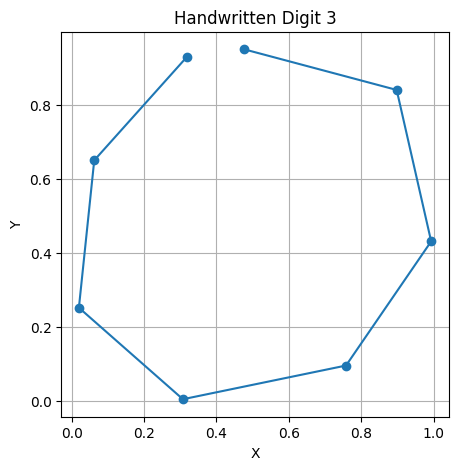

y = [1. 0.]


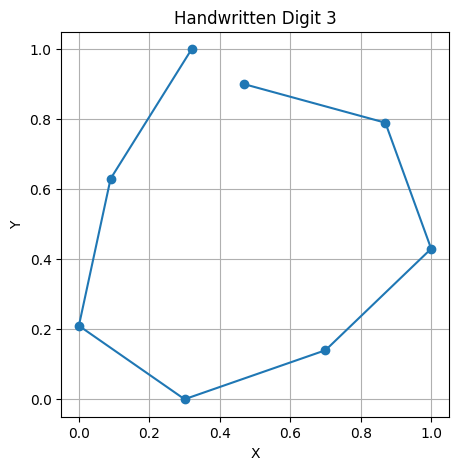

In [17]:
#Testing the autoencoder results
idx = 0
sample = X_test[idx:idx+1]
sample_label = y_test[idx:idx+1]
autoencoded_sample = autoencoder.predict(sample)
visualise_decoded_digit(autoencoded_sample,sample_label)
visualise_digit(X_test,y_test,idx)

In [18]:
#Gettting the Global weights, needed for counterfactuals

from _guided import get_global_weights
from help_functions import evaluate
pos_label = 1
neg_label = 0

step_weights = get_global_weights(
        X,
        y_classes,
        classifier,
        n_timesteps= n_timesteps,
        n_features=n_features,
        random_state=RANDOM_STATE,
)


72/72 [==============================] - 0s 3ms/step


In [19]:
step_weights

array([[[1., 1.],
        [1., 1.],
        [0., 1.],
        [1., 1.],
        [0., 1.],
        [0., 0.],
        [1., 1.],
        [1., 1.]]])

In [20]:
# @title Default title text
import warnings

import numpy as np
import tensorflow as tf
from tensorflow import keras

from wildboar.explain import IntervalImportance
#from LIMESegment.Utils.explanations import LIMESegment


class ModifiedLatentCF:
    """Explanations by generating a counterfacutal sample in the latent space of
    any autoencoder.

    References
    ----------
    Learning Time Series Counterfactuals via Latent Space Representations,
    Wang, Z., Samsten, I., Mochaourab, R., Papapetrou, P., 2021.
    in: International Conference on Discovery Science, pp. 369–384. https://doi.org/10.1007/978-3-030-88942-5_29
    """

    def __init__(
        self,
        probability=0.5,
        *,
        tolerance=1e-6,
        max_iter=100,
        optimizer=None,
        autoencoder=None,
        margin_weight=1.0,  # weighted_steps_weight = 1 - pred_margin_weight
        random_state=None,
        bandwidth,
        weighted_steps_weight,
        data,
        step_weights
    ):
        self.optimizer_ = (
            tf.optimizers.Adam(learning_rate=1e-4) if optimizer is None else optimizer
        )
        #self.x_axis_eights = x_axis_eights
        #self.y_axis_eights = y_axis_eights
        self.data = data
        self.mse_loss_ = keras.losses.MeanSquaredError()
        self.probability_ = tf.constant([probability])
        self.tolerance_ = tf.constant(tolerance)
        self.max_iter = max_iter
        self.autoencoder = autoencoder
        self.random_state = random_state
        self.weighted_steps_weight = weighted_steps_weight
        self.step_weights = step_weights

        # Weights of the different loss components
        self.margin_weight = margin_weight
        self.kde_weight = tf.cast(1 - self.margin_weight-self.weighted_steps_weight,tf.float32)
        if (self.weighted_steps_weight+self.margin_weight)>1.0:
           raise ValueError("(weighted_steps_weight + margin_weight) should be less that 1.0")

        self.bandwidth = bandwidth

    def fit(self, model):
        """Fit a new counterfactual explainer to the model

        Paramaters
        ----------

        model : keras.Model
            The model
        """
        if self.autoencoder:
            (
                encode_input,
                encode_output,
                decode_input,
                decode_output,
            ) = extract_encoder_decoder(self.autoencoder)
            self.decoder_ = keras.Model(inputs=decode_input, outputs=decode_output)
            self.encoder_ = keras.Model(inputs=encode_input, outputs=encode_output)
        else:
            self.decoder_ = None
            self.encoder_ = None
        self.model_ = model
        return self

    def predict(self, x):
        """Compute the difference between the desired and actual probability

        Parameters
        ---------
        x : Variable
            Variable of the sample
        """
        if self.autoencoder is None:
            z = x
        else:
            z = self.decoder_(x)

        return self.model_(z)

    # The "pred_margin_loss" is designed to measure the prediction probability to the desired decision boundary
    def pred_margin_mse(self, prediction):
        return self.mse_loss_(self.probability_, prediction)

    # An auxiliary MAE loss function to measure the proximity with step_weights
    def weighted_mae(self, original_sample, cf_sample, step_weights):
        return tf.math.reduce_mean(
            tf.math.multiply(tf.math.abs(original_sample - cf_sample), step_weights)
        )

    # An auxiliary normalized L2 loss function to measure the proximity with step_weights
    def weighted_normalized_l2(self, original_sample, cf_sample, step_weights):
        var_diff = tf.math.reduce_variance(original_sample - cf_sample)
        var_orig = tf.math.reduce_variance(original_sample)
        var_cf = tf.math.reduce_variance(cf_sample)

        normalized_l2 = 0.5 * var_diff / (var_orig + var_cf)
        return tf.math.reduce_mean(
            tf.math.multiply(
                normalized_l2,
                step_weights,
            )
        )
    #x_axis_eights*self.step_weights_x,use_scotts_rule=False,use_silvermans_rule=True,manual_bandwidth = 0.1
    def train_gaussian_kde(self, data, use_scotts_rule,use_silvermans_rule, manual_bandwidth ):
      """
      Train a Gaussian KDE on the provided data.

      :param data: Multivariate data points used for KDE (2D Tensor).
      :param bandwidth: The bandwidth of the kernel (float).
      :return: A function that represents the trained KDE.
      """

      n = tf.cast(tf.shape(data)[0], tf.float32)
      d = tf.cast(tf.shape(data)[1], tf.float32)
      def kde_fn( x_points):
        """
        Compute the density estimation for given points using the trained KDE.

        :param x_points: Points where the density should be estimated (2D Tensor).
        :return: Density estimates (Tensor).
        """
        d = tf.cast(tf.shape(data)[1], tf.float32)
        #print(f'data.shape = {data.shape}')
        #data.shape = (732, 8)

        data_exp =  tf.expand_dims(data, axis=0)
        #print(f'data dimentions = {data_exp.shape}')
        #data dimentions = (1, 732, 8)

        x_points_exp = tf.reshape(x_points, (tf.shape(x_points)[0], 8, 1))
        #print(f'x_points dimentions = {x_points_exp.shape}')
        #x_points dimentions = (732, 8, 1)

        x_points_exp = tf.expand_dims(x_points_exp, axis=1)
        #print(f'x_points dimentions = {x_points_exp.shape}')

        if use_scotts_rule:
          sigma = tf.math.reduce_std(data)
          sigma = tf.cast(sigma,tf.float32)
          bandwidth = n ** (-1.0 / (d + 4)) * sigma
        elif use_silvermans_rule:
          sigma = tf.math.reduce_std(data)
          bandwidth = (4 * sigma**5 / (3 * n)) ** (1/5)
        else:
          if manual_bandwidth is None:
            raise ValueError("Manual bandwidth must be provided if not using Scott's Rule.")
          bandwidth = manual_bandwidth

        bandwidth = tf.cast(bandwidth, tf.float32)
        #print(f'n = {n}')
        #print(f'd = {d}')
        #print(f'bandwidth = {bandwidth}')
        x_points_exp = tf.cast(x_points_exp,tf.float32)
        data_exp= tf.cast(data_exp, tf.float32)
        #print(x_points_exp.dtype, data_exp.dtype)
        diff = x_points_exp - data_exp
        norm = tf.reduce_sum(diff ** 2, axis=2)
        kernel_val = tf.exp(-norm / (2.0 * bandwidth ** 2))


        d = tf.constant(d,tf.float32)
        density = tf.reduce_mean(kernel_val, axis=1) / (bandwidth * tf.sqrt(2.0 * np.pi * d))
        return density

      return kde_fn

    def gaussian_kde_logpdf(self, kde_fn, x_points):
      """
      Evaluate the logpdf of the given points using the trained KDE function.

      :param kde_fn: Trained KDE function.
      :param x_points: Points to evaluate the logpdf (2D Tensor).
      :return: Log of the density estimates (Tensor).
      """
      #print(f'x_points.shape in gaussian kde lofpdf= {x_points.shape}')
      density = kde_fn(x_points)
      return tf.math.log(density)


    # additional input of step_weights
    def compute_loss(self,original_sample, z_search, target_label, kde_stop):
        loss = tf.zeros(shape=())
        decoded = self.decoder_(z_search) if self.autoencoder is not None else z_search
        pred = self.model_(decoded)[:, target_label]

        #margin loss (y-τ)
        margin_loss = self.pred_margin_mse(pred)
        loss += self.margin_weight * margin_loss

        kde_diffrences = []
        for dimention in range(decoded.shape[2]):
          data_dimention = self.data[:,:,dimention]
          data_dimention = data_dimention[:,:,np.newaxis]
          #print(f'data_dimention in compute loss = {data_dimention.shape}')
          kde = self.train_gaussian_kde(data = data_dimention,use_scotts_rule=False,use_silvermans_rule=False,manual_bandwidth = self.bandwidth)
          mean_log_likelihood = tf.cast(tf.reduce_mean(self.gaussian_kde_logpdf(kde, x_points = (data_dimention))),tf.float32)

          decoded_dimention = decoded[:,:,dimention]
          decoded_dimention = decoded_dimention[:,:,np.newaxis]
          #print(f'decoded_dimention in compute loss = {decoded_dimention.shape}')
          log_likelihood_of_sample = tf.cast(self.gaussian_kde_logpdf(kde, x_points = (decoded_dimention)),tf.float32)

          # kde_x = self.train_gaussian_kde(data = self.x_axis_eights,use_scotts_rule=False,use_silvermans_rule=False,manual_bandwidth = self.bandwidth)
          # kde_y = self.train_gaussian_kde(data = self.y_axis_eights,use_scotts_rule=False,use_silvermans_rule=False,manual_bandwidth = self.bandwidth)
          # mean_log_likelihood_ofData_x = tf.cast(tf.reduce_mean(self.gaussian_kde_logpdf(kde_x, x_points = ( self.x_axis_eights))),tf.float32)
          # mean_log_likelihood_ofData_y = tf.cast(tf.reduce_mean(self.gaussian_kde_logpdf(kde_y, x_points = ( self.y_axis_eights))),tf.float32)


          #The likelihood of the distribution beeing neer to the mean of the distributions of the known data (mean.likelihood(d) - likelihood(sample))
          # decoded_x =  decoded [:,:,0:1]
          # decoded_y =  decoded [:,:,1:2]
          # log_likelihood_ofSample_x = tf.cast(self.gaussian_kde_logpdf(kde_x, x_points = (decoded_x)),tf.float32)
          # log_likelihood_ofSample_y = tf.cast(self.gaussian_kde_logpdf(kde_y, x_points = (decoded_y)),tf.float32)
          # print(log_likelihood_ofSample_x.dtype)
          #print(f'mean_log_likelihood = {mean_log_likelihood}')
          #print(f'log_likelihood_of_sample.shape = {log_likelihood_of_sample.shape}')
          kde_loss = tf.cast((mean_log_likelihood - log_likelihood_of_sample),tf.float32)
          #kde_loss = tf.math.abs(kde_loss)
          #print(kde_loss)
          kde_diffrences.append(kde_loss)
        #print(kde_diffrences)
        #kde_total_loss = tf.reduce_mean(kde_diffrences)
        kde_total_loss = tf.math.add_n(kde_diffrences)
        kde_total_loss = tf.math.abs(kde_total_loss)
        #print(kde_total_loss)
        loss +=self.kde_weight *kde_total_loss


        weighted_steps_loss = self.weighted_mae(
            original_sample=tf.cast(original_sample, dtype=tf.float32),
            cf_sample=tf.cast(decoded, dtype=tf.float32),
            step_weights=tf.cast(step_weights, tf.float32),
        )
        loss += self.weighted_steps_weight * weighted_steps_loss

        return loss, margin_loss, kde_loss, kde_stop

    # TODO: compatible with the counterfactuals of wildboar
    #       i.e., define the desired output target per label


    def transform(self, x, pred_labels):
        """Generate counterfactual explanations

        x : array-like of shape [n_samples, n_timestep, n_dims]
            The samples
        """

        result_samples = np.empty(x.shape)
        losses = np.empty(x.shape[0])
        # `weights_all` needed for debugging
        weights_all = np.empty((x.shape[0], 1, x.shape[1], x.shape[2]))
        for i in range(x.shape[0]):
            print(f"sample {i+1} is beeing transformed.")
            kde_stop = False

            x_sample, loss = self._transform_sample(
                x[np.newaxis, i], pred_labels[i],kde_stop
            )

            result_samples[i] = x_sample
            losses[i] = loss
            weights_all[i] = step_weights

        print(f"{i+1} samples been transformed, in total.")

        return result_samples, losses, weights_all

    def _transform_sample(self, x, pred_label,kde_stop):
        """Generate counterfactual explanations(z))"""
        # TODO: check_is_fitted(self)
        if self.autoencoder is not None:
            z = tf.Variable(self.encoder_(x))
        else:
            z = tf.Variable(x, dtype=tf.float32)

        it = 0
        target_label = 1 - pred_label  # for binary classification

        #def compute_loss(self,original_sample, z_search, target_label)
        with tf.GradientTape(persistent = True) as tape:
            loss, pred_margin_loss, kde_loss, kde_stop = self.compute_loss(
                x, z,  target_label,kde_stop
            )
        if self.autoencoder is not None:
            pred = self.model_(self.decoder_(z))
        else:
            pred = self.model_(z)

        # # uncomment for debug
        # print(
        #     f"current loss: {loss}, pred_margin_loss: {pred_margin_loss}, weighted_steps_loss: {weighted_steps_loss}, pred prob:{pred}, iter: {it}."
        # )

        # TODO: modify the loss to check both validity and proximity; how to design the condition here?
        # while (pred_margin_loss > self.tolerance_ or pred[:, 1] < self.probability_ or weighted_steps_loss > self.step_tolerance_)?
        # loss > tf.multiply(self.tolerance_rate_, loss_original)


        while (
            (loss > self.tolerance_
            and pred[:, target_label] < self.probability_)
            and (it < self.max_iter if self.max_iter else True)
            ) :
            # Get gradients of loss wrt the sample
            grads = tape.gradient(loss, z)
            # Update the weights of the sample
            self.optimizer_.apply_gradients([(grads, z)])
            del tape

            #self,original_sample, z_search, target_label
            with tf.GradientTape(persistent=True) as tape:
                loss, pred_margin_loss, kde_loss, kde_stop = self.compute_loss(
                    x, z,  target_label,kde_stop
                )

            kde_loss = tf.convert_to_tensor(kde_loss, dtype=tf.float32)
            grads = tape.gradient(loss, z)
            # Optionally, compute and log gradients for individual components
            kde_grads = tape.gradient(kde_loss, z)
            margin_grads = tape.gradient(pred_margin_loss, z)


            it += 1
            # if it % 50 == 0:
            #   # print(f'Currently on iteration: {it}.')
            #   # print(f'kde loss : {kde_loss}')
            #   # print(f'margin loss : {pred_margin_loss}')
            #   # print(f'loss : {loss}')

            #   if kde_grads is  None:
            #     print("KDE Gradients are None.")
            if self.autoencoder is not None:
                pred = self.model_(self.decoder_(z))
            else:
                pred = self.model_(z)

        # # uncomment for debug
        # print(
        #     f"current loss: {loss}, pred_margin_loss: {pred_margin_loss}, weighted_steps_loss: {weighted_steps_loss}, pred prob:{pred}, iter: {it}. \n"
        # )

        res = z.numpy() if self.autoencoder is None else self.decoder_(z).numpy()
        return res, float(loss)


In [ ]:
reset_seeds()

cf_model = ModifiedLatentCF(
    probability=0.9,
    tolerance=1e-6,
    max_iter=500,
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
    autoencoder = autoencoder,
    margin_weight=0.6,
    random_state= RANDOM_STATE,
    bandwidth = 0.5,
    weighted_steps_weight = 0.2,
    data = X_train[y_train_classes == 1],
    step_weights = step_weights
    )
cf_model.fit(classifier)


y_neg = y_classes[y_classes == 0]
X_neg = X[y_classes == 0]

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    cf_embeddings, losses, weights = cf_model.transform(x = X_neg,pred_labels = y_neg)


actual
y = 0


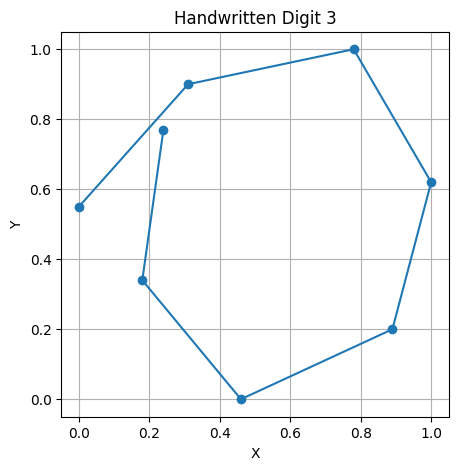

counterfactual
y = 0


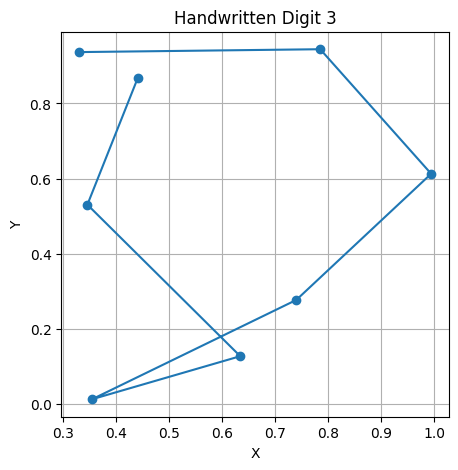

actual
y = 0


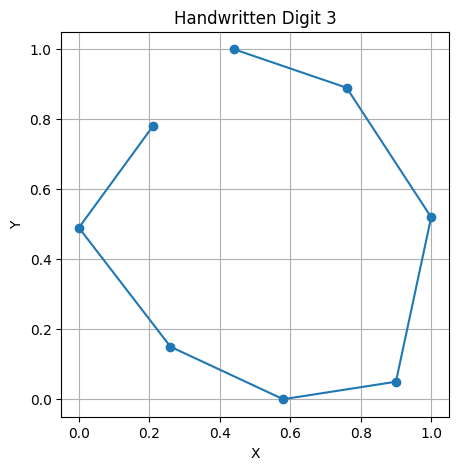

counterfactual
y = 0


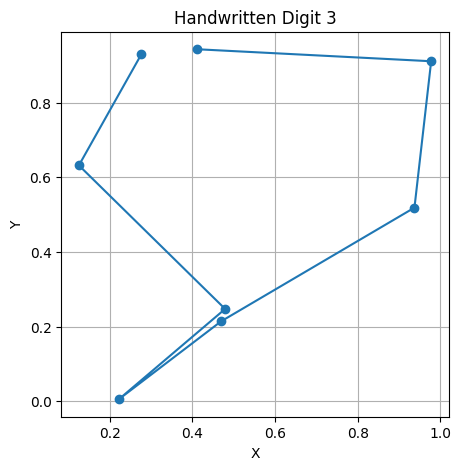

actual
y = 0


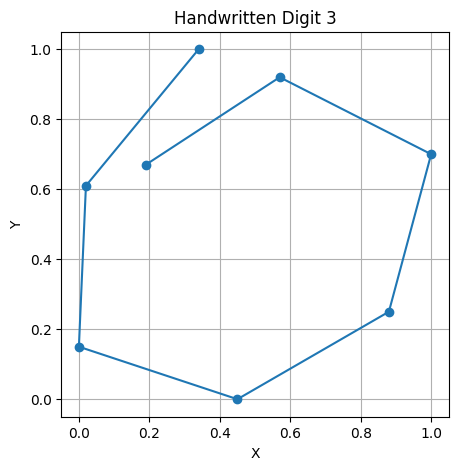

counterfactual
y = 0


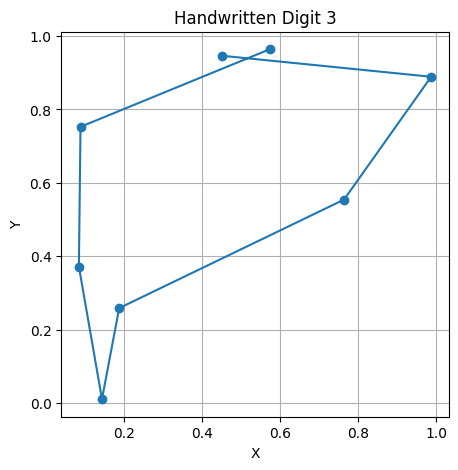

actual
y = 0


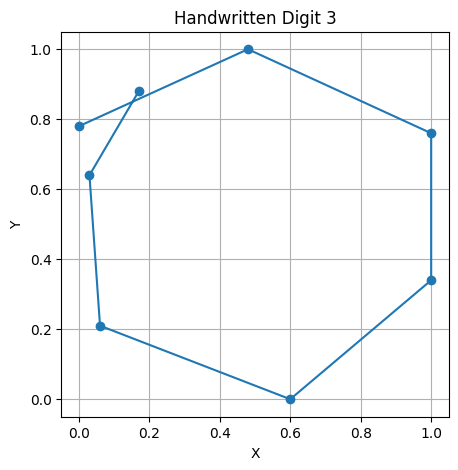

counterfactual
y = 0


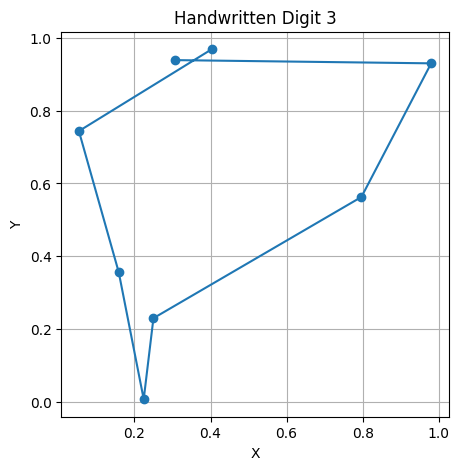

actual
y = 0


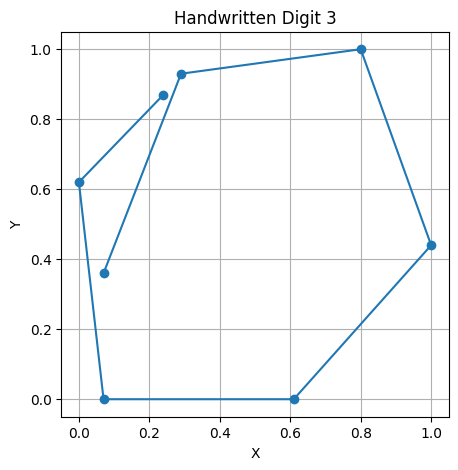

counterfactual
y = 0


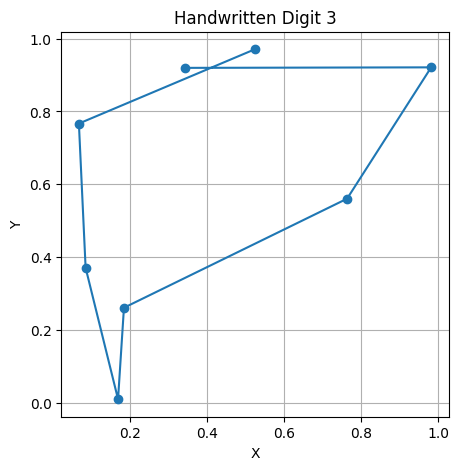

In [22]:
#with learning rate = 0.001, 500 iterations, bandwidth = 0.1,margin_weight=0.6,weighted_steps_weight = 0.2,kse_weight = 0.2
for i in range(5):
  i=i+30
  print("actual")
  visualise_digit(X_neg,y_neg,i,figsize = (5,5))
  print("counterfactual")
  visualise_digit(cf_embeddings,y_neg,i,figsize = (5,5))


In [23]:
#Validity
cf_pred = classifier.predict(cf_embeddings)[:, 1] # predicted probabilities of CFs
cf_pred_labels = cf_pred
for idx in range(cf_pred_labels.shape[0]):
  if cf_pred_labels[idx] > 0.5:
    cf_pred_labels[idx] = 1
  else:
    cf_pred_labels[idx] = 0


print(f'Transformation_finished with validity_score = {validity_score(y_neg,cf_pred_labels)}')

4/4 [==============================] - 0s 7ms/step
Transformation_finished with validity_score = 0.95


In [24]:
#Calculating proximity withour absolute
from tensorflow.keras.losses import MeanSquaredError
total_mse = 0
probability = 0.9
for idx in range(cf_embeddings.shape[0]):
    counterfactual = cf_embeddings[idx,np.newaxis]
    prediction = classifier.predict(counterfactual)[:, 1]
    mse = MeanSquaredError()
    mse_dist = mse(probability, prediction).numpy()
    total_mse +=mse_dist
mean_mse = total_mse /cf_embeddings.shape[0]
print(f"The Mean MSE of the data is: {mean_mse} ")

1/1 [==============================] - 0s 31ms/step
The Mean MSE of the data is: 0.04435060490809747 


In [25]:
print(f"The Mean MSE of the data is: {mean_mse} ")

The Mean MSE of the data is: 0.04435060490809747 


In [26]:
#Calculating proximity with absolute
from tensorflow.keras.losses import MeanSquaredError
total = 0
probability = 0.9
for idx in range(cf_embeddings.shape[0]):
    counterfactual = cf_embeddings[idx,np.newaxis]
    prediction = classifier.predict(counterfactual)[:, 1]
    dist = abs(prediction - probability)
    total +=dist
mean_mse = total /cf_embeddings.shape[0]
print(f"The Mean MSE of the data is: {mean_mse} ")

1/1 [==============================] - 0s 31ms/step
The Mean MSE of the data is: [0.10083196] 


In [27]:
print(f"The Mean MSE of the data is: {mean_mse} ")

The Mean MSE of the data is: [0.10083196] 


In [28]:
#Proximity
def euclidean_distance(X, cf_samples):
    paired_distances = np.linalg.norm(X - cf_samples, axis=1)
    return np.mean(paired_distances)
euclidean_distance(X_neg, cf_embeddings)

0.6595914778975265

In [29]:
from scipy.stats import gaussian_kde

diffrences_from_abnormal = []
diffrences_from_normal = []
for dimention in range(cf_embeddings.shape[2]):


  abnormal_data = X[y_classes == 1][:,:,dimention]
  normal_data = X[y_classes == 0][:,:,dimention]
  counterf_data = cf_embeddings[:,:,dimention]

  #get the kernel for every dimention of the trained
  kernel = gaussian_kde(abnormal_data.T,bw_method=None)

  #get all the log likelihoods
  log_likelihood_abnormal = np.mean(kernel.logpdf(abnormal_data.T))
  log_likelihood_normal = np.mean(kernel.logpdf(normal_data.T))
  log_likelihood_counterfactual = np.mean(kernel.logpdf(counterf_data.T))

  #get the diffrences from the counterfactuals
  diff_from_abnormal = abs(log_likelihood_counterfactual-log_likelihood_abnormal)
  diffrences_from_abnormal.append(diff_from_abnormal)

  diff_from_normal = abs(log_likelihood_counterfactual-log_likelihood_normal)
  diffrences_from_normal.append(diff_from_normal)


In [30]:
diffrences_from_normal

[5.008989694833277, 7.230929772132672]

In [31]:
diffrences_from_abnormal

[3.158871178009611, 0.7342209194518201]